$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cM {\mathcal{M}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$
$\newcommand{\rd}{\mathop{}\!\mathrm{d}}$

# Guessing the field parameter $y$ through the PDE residual

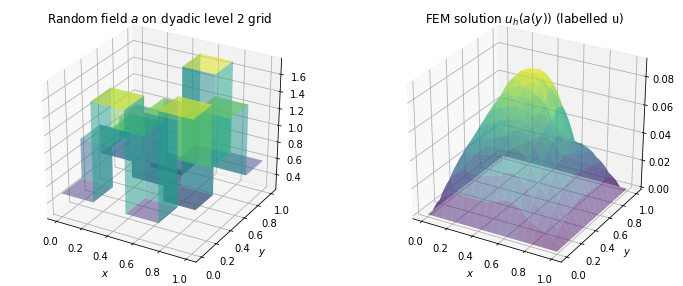

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

%matplotlib inline

def make_soln(points, field_space, fem_space, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = hil.Basis(np.zeros((H1_fine.n, len(points))), space=H1_fine)
    fields = []
    
    for i, p in enumerate(points):
        field = hil.Vector(a_bar + c * p, space=field_space)
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = hil.DyadicFEMSolver(fem_space = fem_space, rand_field = field, f = 1)
        fem_solver.solve()
        solns._values[:,i] = fem_solver.u.values
        
    return solns, fields

fem_div = 7
H1_fine = hil.H1DyadicSq(fem_div)
field_div = 2
L2_coarse = hil.L2DyadicSq(field_div)
a_bar = 1.0
c = 0.9
side_n = 2**field_div
d = side_n * side_n
y_range = np.zeros((d,2))
y_range[:,0] = -1.0
y_range[:,1] = 1.0

def diffusion_pde(points):
    solns, fields = make_soln(points, field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
    return solns

np.random.seed(5)
y = np.random.random((1,d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
u, a = make_soln(y, field_space=L2_coarse, fem_space=H1_fine, a_bar=a_bar, c=c)
u = u[0]; a = a[0]
                           
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u}$)')
plt.show()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

# Our first task is to test the inverse $y$ estimator routine

This is done through a series of calculations, observing that for any given $v\in V$ (that is at least hopefully somewhere near the variety $\cM = \{ u(y) : y \in Y \}$

$$
\arg \min_{y \in Y} \| u^* - u(y) \|_V,
$$

with the idea being that $u^*$ comes from some optimal recovery process. Now the observation is that

$$
\begin{aligned}
\| u^* - u(y) \|_V 
&\sim \| \mathrm{div} (a(y) \nabla (u^* - u(y))) \|_{V'} \\
&= \| \mathrm{div} (a(y) \nabla u^*) + f \|_{V'} \\
&= \left\| \mathrm{div} (\bar a \nabla u^*)  + f + \sum_{i=1}^d y_i \mathrm{div}(\psi_i \nabla u^*) \right\|_{V'}
\end{aligned}
$$

So now we want to minimise this last expression, or find

$$
\begin{aligned} \label{eq:min}
{\arg \min}_{y\in Y} \left\| \mathrm{div} (\bar a \nabla u^*)  + f + \sum_{i=1}^d y_i \mathrm{div}(\psi_i \nabla u^*) \right\|_{V'}^2
= {\arg \min}_{y\in Y} \left\| \phi_0 + \sum_{i=1}^d y_i \phi_j \right\|_{V}^2
\end{aligned}
$$

where now the $\phi_j \in V$ are the representers of $\mathrm{div}(\psi_i \nabla u^*)$ and $\phi_0$ of $\mathrm{div} (\bar a \nabla u^*) + f$. We calculate this explicitly through the usual Galerkin equivalence:

$$
\int \nabla \phi_0 \cdot \nabla v \rd x = \int f v \rd x + \int \bar a \nabla u^* \cdot \nabla v \rd x
$$
and
$$
\int \nabla \phi_j \cdot \nabla v \rd x = \int \psi_j \nabla u^* \cdot \nabla v \rd x
$$

Then the solution to the minimisation problem is a linear system

In [3]:
N_tr = 200
N_te = 10

np.random.seed(1)
points_tr = np.random.random((N_tr, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
us_tr = diffusion_pde(points_tr)
points_te = np.random.random((N_te, d)) * (y_range[:, 1] - y_range[:, 0]) + y_range[:, 0]
us_te = diffusion_pde(points_te)

n = 13
greedy = rm.GreedyApprox(us_tr)
Vn = greedy.construct_to_n(n)

y_guesser = hil.DyadicGuesser(field_mean=a_bar, field_mult=c, fem_space=H1_fine, field_space=L2_coarse, y_bounds=y_range)

# First: we get perfect recovery of $y$ when we fit to a perfect solution $u(y)$.

### in the following $y^*$ is the guess of $y$, and we see they agree within machine tolerance

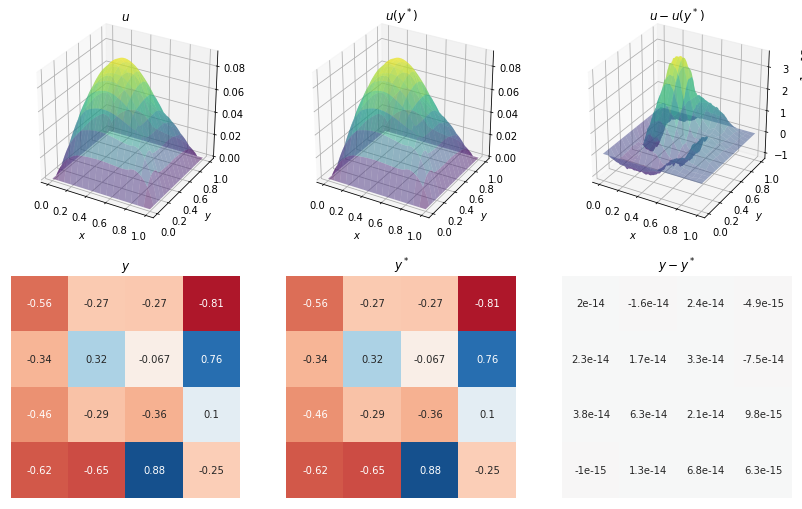

In [4]:
#n_show = 1
#for u_te, w_te, y_te in zip(us_te[:n_show], ws_te.T[:n_show], points_te[:n_show]):
u_te = us_te[0]
y_te = points_te[0]

y_guess, residual = y_guesser.nearest_params_resid(u_te)
us_guess = diffusion_pde([y_guess])[0]

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(2, 3, 1, projection='3d')
u_te.plot(ax, title=r'$u$')
ax = fig.add_subplot(2, 3, 2, projection='3d')
us_guess.plot(ax, title=r'$u(y^*)$')
ax = fig.add_subplot(2, 3, 3, projection='3d')
(u_te - us_guess).plot(ax, title=r'$u - u(y^*)$')
ax = fig.add_subplot(2, 3, 4)
sns.heatmap(y_te.reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
ax.set_title(r'$y$')
ax = fig.add_subplot(2, 3, 5)
sns.heatmap((y_guess).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
ax.set_title(r'$y^*$')
ax = fig.add_subplot(2, 3, 6)
sns.heatmap((y_te-y_guess).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
ax.set_title(r'$y-y^*$')
plt.show()

# Compare the $y$ fit on a raw measurement $w$ vs a reconstruction $u^*$

Here if we minimise the residual over $y\in Y$ for the measurement $w$ and for a linear reconstruction $u^*$, let us denote

$$
\begin{aligned}
y^*(w) &= \arg\min_{y\in Y} \| A(y) w - f \|_{V'} \\
y^*(u^*) &= \arg\min_{y\in Y} \| A(y) u^* - f \|_{V'}
\end{aligned}
$$

We look at the size of these residuals and then compute the solutions for both these minimised parameters.

In [5]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 5

Wm_reg, W_L2_reg, Wloc_reg = rm.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm = Wm_reg.orthonormalise()

m = Wm.n
print(f'm={m}')
    
ws_te = Wm.A @ us_te

Vn_ortho = Vn.orthonormalise()
lin_est = rm.LinearWorstCaseEstimator(Vn_ortho, Wm=Wm)

m=16


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

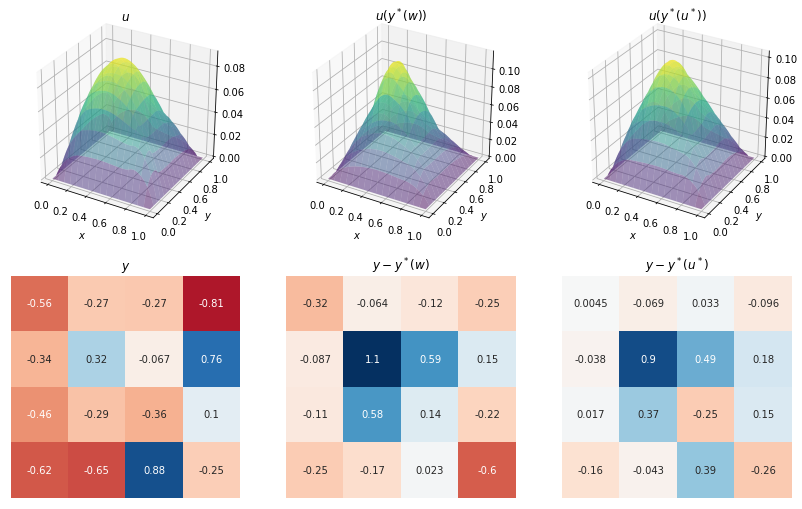

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

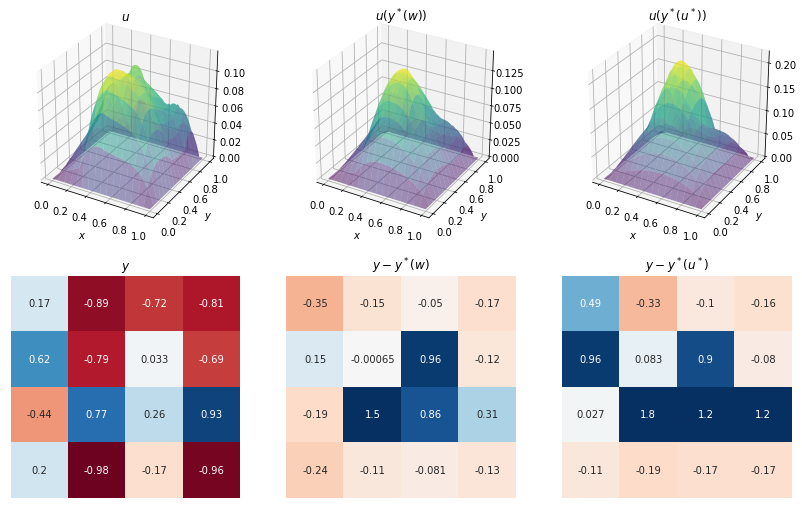

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

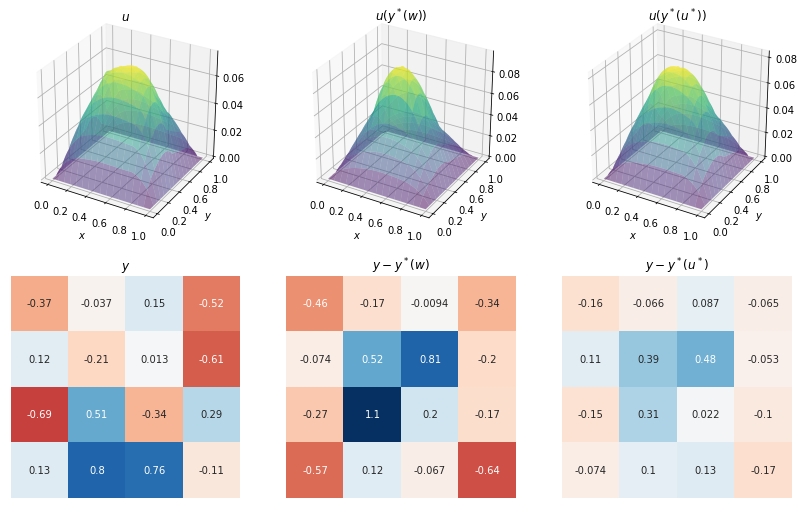

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

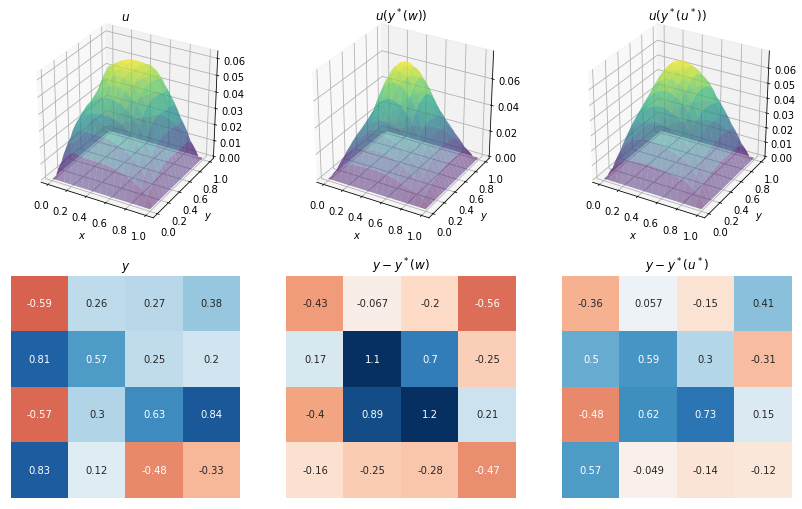

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

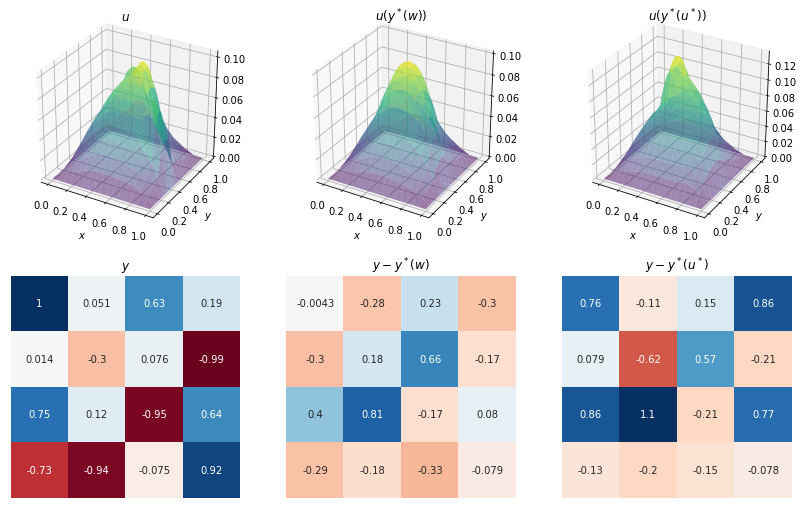

In [6]:
n_show = 5
for i, (u_te, w_te, y_te) in enumerate(zip(us_te[:n_show], ws_te.T[:n_show], points_te[:n_show])):
    u_star = lin_est.best_estimate(w_te)
    w = Wm.dot_to_projection(w_te)
    y_guess_star, residual_star = y_guesser.nearest_params_resid(u_star)
    y_guess_w, residual_w = y_guesser.nearest_params_resid(w)
    
    us_guess_star = diffusion_pde([y_guess_star])[0]
    us_guess_w = diffusion_pde([y_guess_w])[0]
    
    display(Latex(f'Test point {i+1}'))
    display(Latex(rf'$\| A(y^*(w)) w - f \|_{{V^*}}$ = {residual_w}, $\quad\| u(y^*(w)) - u(y) \|_{{V}}$ = {(us_guess_w - u_te).norm()}'))
    display(Latex(rf'$\| A(y^*(u^*)) u^* - f \|_{{V^*}}$ = {residual_star}, $\quad\| u(y^*(u^*)) - u(y) \|_{{V}}$ = {(us_guess_star - u_te).norm()}'))
    
    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    u_te.plot(ax, title=r'$u$')
    ax = fig.add_subplot(2, 3, 2, projection='3d')
    us_guess_w.plot(ax, title=r'$u(y^*(w))$')
    ax = fig.add_subplot(2, 3, 3, projection='3d')
    us_guess_star.plot(ax, title=r'$u(y^*(u^*))$')
    
    ax = fig.add_subplot(2, 3, 4)
    sns.heatmap(y_te.reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(r'$y$')
    ax = fig.add_subplot(2, 3, 5)
    sns.heatmap((y_te - y_guess_w).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(r'$y-y^*(w)$')
    ax = fig.add_subplot(2, 3, 6)
    sns.heatmap((y_te - y_guess_star).reshape((side_n,side_n)), cmap='RdBu', center=0, vmin=-1.0, vmax=1.0, cbar=False, xticklabels=False, yticklabels=False, annot=True)
    ax.set_title(r'$y-y^*(u^*)$')
    plt.show()